In [27]:
library(data.table)
library(stringr)
library(plyr)
library(ggplot2)
library(ggpubr)


## 1. mutation number comparison (fig.1H)

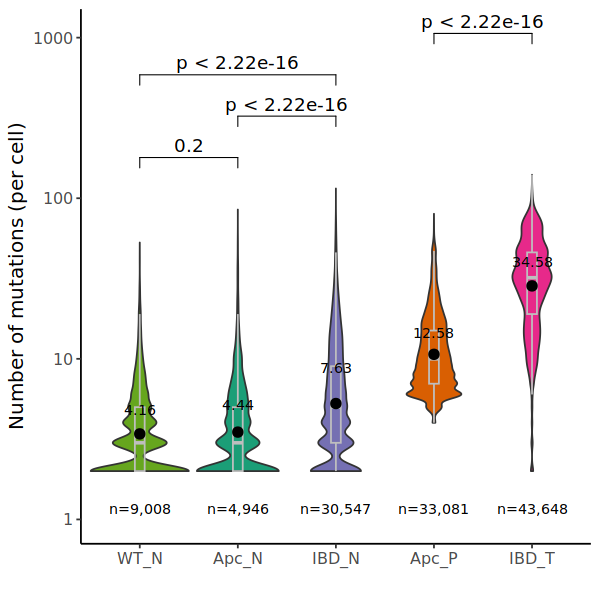

In [72]:
INDIR = "/data2/kantian/LineageTracing/SMALT/0.Results/2.final_phy_re/"
# INDIR = "/data2/kantian/LineageTracing/SMALT/0.Results/2.final_phy/"
OUTDIR = "/data2/kantian/LineageTracing/SMALT/0.Results/figures/"
# samplelist <- read.delim("F:/SMALT/Results/sample_list_phy_filtered.txt",header = T)
# setDT(samplelist)
# samplelist[, sampleType := paste0(cat, "_",type)]
sampleTypes = c("WT_N","Apc_N","IBD_N","Apc_P","IBD_T")
samplesall = list(c("WT1_N5","WT1_N7","WT2_N3","WT2_N5"),
                  c("68_N","72_N","71_N","75_N"),
                  c("2_N","4_N","5_N","16_N","19_N","47_N1","47_N4","47_N5","47_N6","47_N8",
                    "49_N","50_N","65_N","66_N", "17_N","151_N","142_N","148_N"),#"132_N","18_N"
                  c("68_P1","68_P2","68_P3","68_P4","68_P5-1","68_P5-2","68_P5-3",
                    "68_P5-4","68_P5-5","72_P1","72_P2","72_P4","72_P5","72_P6","72_P8","72_P9",
                    "71_P3","75_P3","75_P5","75_P8","75_P11"),
                  c("2_T2","2_T3","4_T","5_T","16_T","47_T1","47_T4","47_T5","47_T6","47_T8",
                    "49_T1","49_T3","50_T","65_T1","65_T3","66_T","19_T1","19_T3","19_T4","19_T5",
                    "132_T1","151_T4","17_T4","18_T3","18_T4","142_T1","142_T2","142_T5-4","148_T1","148_T3")
                  )
dt <- data.table()
for(my.type in 1:length(sampleTypes)){
  # message("Calculating ", my.type, "...")
  subs <- samplesall[[my.type]]
  for(my.sample in subs){
    # message("\tCalculating ", my.sample, "...")
    x <- read.delim(paste0(INDIR,my.sample,"_filtered_re.phy"),header = F, sep = " ",
                    colClasses=c("character","character"),skip = 2,
                    col.names = c("cellID","bi"))
    setDT(x)
    setkey(x, cellID)
    new <- lapply(as.list(x$cellID),function(i){
      temp <- x[.(i)]$bi
      data.table(cellID = i, numMut = str_count(temp,"1"))
    })
    new <- rbindlist(new)
    # print(min(new$numMut))
    new$sample = my.sample
    new$sampleType = sampleTypes[my.type]
    dt <- rbind(dt, new)
  }
}
stats = ddply(dt, .(sampleType, sample), summarize, mouseID=unlist(strsplit(sample[1],"_"))[1],
              sampleID=unlist(strsplit(sample[1],"_"))[2],numCell=length(cellID),
              med = median(numMut),mean = round(mean(numMut),2),min=min(numMut))
##-----------------------------------------
meds <- ddply(dt, .(sampleType), summarize, med = median(numMut),mean = mean(numMut),min=min(numMut))
my_comparisons <- list(c("Apc_N","WT_N"),c("Apc_N","IBD_N"),c("WT_N","IBD_N"),c("IBD_T","Apc_P"))#,c("Apc_N","WT_N")
# dt$sampleType <- factor(dt$sampleType, levels = c("WT_N","IBD_N","Apc_N","IBD_T","Apc_P"))
dt$sampleType <- factor(dt$sampleType, levels = c("WT_N","Apc_N","IBD_N","Apc_P","IBD_T"))
samplesize = data.table(table(dt$sampleType))
colnames(samplesize) <- c("sampleType","numCell")
##
mycols <- c("#66A61E","#1B9E77","#7570B3","#D95F02","#E7298A") 
p1 <- ggplot(dt, aes(x=sampleType, y=numMut,fill=sampleType))+
  geom_violin(width=1) +
  geom_boxplot(width=0.1,color = "grey",alpha = 0.2, outlier.shape = NA)+
  geom_text(data=meds, aes(y=mean, label = round(mean,2)),size = 3, vjust = -0.5)+
  geom_text(data=samplesize, aes(y=1, label = paste0("n=",scales::comma(numCell))),size = 3, vjust = -0.5)+
  labs(x="", y="Number of mutations (per cell)")+theme_classic()+#ggtitle("")+
  scale_y_log10()+ #ggtitle("All samples")+
  theme(text = element_text(size=12),plot.title = element_text(hjust = 0.5, size = 12),
        legend.position="none")+ #axis.text.x = element_text(angle = 30, vjust = 1, hjust=1),
  stat_compare_means(comparisons = my_comparisons)+
  stat_summary(fun=mean, geom='point', shape=20, size=4)+
  scale_fill_manual(values=mycols)
# pdf(file = paste0(OUTDIR,"fig1H.mutation_numbers_comparison.pdf"), height = 4, width = 4.5)
# p1
# dev.off()

write.table(dt, file=paste0(OUTDIR, "2.1.mutations_per_cell.txt"),sep="\t", row.names=F, quote=F)

p1

In [28]:
meds

sampleType,med,mean,min
<chr>,<dbl>,<dbl>,<int>
Apc_N,3,4.439143,2
Apc_P,10,12.576947,4
IBD_N,5,7.632304,2
IBD_T,32,34.580599,2
WT_N,3,4.157527,2


In [73]:
OUTDIR = "/data2/kantian/LineageTracing/SMALT/0.Results/figures/"
write.table(stats, file=paste0(OUTDIR, "3.1.CRC_Apc_stats.txt"),sep="\t", row.names=F, quote=F)
stats <- read.delim(paste0(OUTDIR, "3.1.CRC_Apc_stats.txt"), header = T)
stats[1:10,]

,sampleType,sample,mouseID,sampleID,numCell,med,mean,min
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<int>
1,Apc_N,68_N,68,N,775,3,3.79,2
2,Apc_N,71_N,71,N,660,2,3.11,2
3,Apc_N,72_N,72,N,2284,3,5.04,2
4,Apc_N,75_N,75,N,1227,3,4.45,2
5,Apc_P,68_Ade1,68,Ade1,1042,7,8.14,5
6,Apc_P,68_Ade2,68,Ade2,1634,8,10.02,5
7,Apc_P,68_Ade3,68,Ade3,785,9,11.30,5
8,Apc_P,68_Ade4,68,Ade4,2012,10,11.37,5
9,Apc_P,68_Ade5-1,68,Ade5-1,924,41,41.19,20


## 2. mutation number comparison -- DSS vs DSS/AOM (fig.1H)

png 
  2

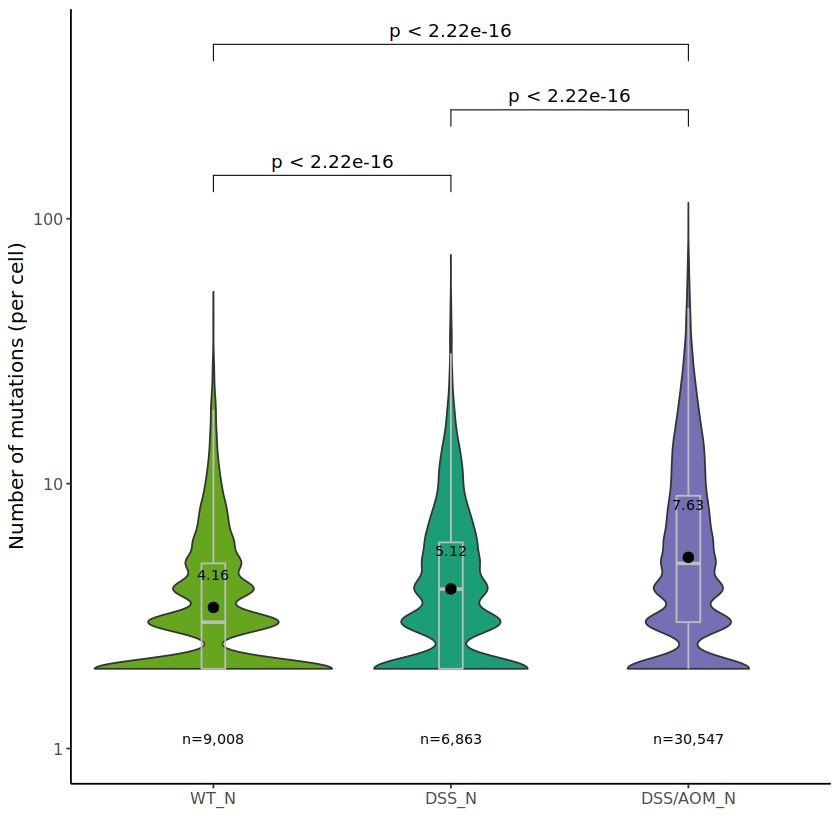

In [11]:
INDIR = "/data2/kantian/LineageTracing/SMALT/0.Results/2.final_phy_re/"
OUTDIR = "/data2/kantian/LineageTracing/SMALT/0.Results/figures/"
# samplelist <- read.delim("F:/SMALT/Results/sample_list_phy_filtered.txt",header = T)
# setDT(samplelist)
# samplelist[, sampleType := paste0(cat, "_",type)]
sampleTypes = c("WT_N","DSS_N","DSS/AOM_N")
samplesall = list(c("WT1_N5","WT1_N7","WT2_N3","WT2_N5"),
                  c("34_N_E","40_N_E"), #IBD week30
                  c("2_N","4_N","5_N","16_N","19_N","47_N1","47_N4","47_N5","47_N6","47_N8",
                    "49_N","50_N","65_N","66_N", "17_N","151_N","142_N","148_N"))
dt <- data.table()
for(my.type in 1:length(sampleTypes)){
  # message("Calculating ", my.type, "...")
  subs <- samplesall[[my.type]]
  for(my.sample in subs){
    # message("\tCalculating ", my.sample, "...")
    x <- read.delim(paste0(INDIR,my.sample,"_filtered_re.phy"),header = F, sep = " ",
                    colClasses=c("character","character"),skip = 2,
                    col.names = c("cellID","bi"))
    setDT(x)
    setkey(x, cellID)
    new <- lapply(as.list(x$cellID),function(i){
      temp <- x[.(i)]$bi
      data.table(cellID = i, numMut = str_count(temp,"1"))
    })
    new <- rbindlist(new)
    # print(min(new$numMut))
    new$sample = my.sample
    new$sampleType = sampleTypes[my.type]
    dt <- rbind(dt, new)
  }
}
stats = ddply(dt, .(sampleType, sample), summarize, mouseID=unlist(strsplit(sample[1],"_"))[1],
              sampleID=unlist(strsplit(sample[1],"_"))[2],numCell=length(cellID),
              med = median(numMut),mean = round(mean(numMut),2),min=min(numMut))
##-----------------------------------------
meds <- ddply(dt, .(sampleType), summarize, med = median(numMut),mean = mean(numMut),min=min(numMut))
my_comparisons <- list(c("WT_N","DSS_N"),c("DSS_N","DSS/AOM_N"),c("WT_N","DSS/AOM_N"))
dt$sampleType <- factor(dt$sampleType, levels = c("WT_N","DSS_N","DSS/AOM_N"))
samplesize = data.table(table(dt$sampleType))
colnames(samplesize) <- c("sampleType","numCell")
##
mycols <- c("#66A61E","#1B9E77","#7570B3","#D95F02","#E7298A") 
p1 <- ggplot(dt, aes(x=sampleType, y=numMut,fill=sampleType))+
  geom_violin(width=1) +
  geom_boxplot(width=0.1,color = "grey",alpha = 0.2, outlier.shape = NA)+
  geom_text(data=meds, aes(y=mean, label = round(mean,2)),size = 3, vjust = -0.5)+
  geom_text(data=samplesize, aes(y=1, label = paste0("n=",scales::comma(numCell))),size = 3, vjust = -0.5)+
  labs(x="", y="Number of mutations (per cell)")+theme_classic()+#ggtitle("")+
  scale_y_log10()+ #ggtitle("All samples")+
  theme(text = element_text(size=12),plot.title = element_text(hjust = 0.5, size = 12),
        legend.position="none")+ #axis.text.x = element_text(angle = 30, vjust = 1, hjust=1),
  stat_compare_means(comparisons = my_comparisons)+
  stat_summary(fun=mean, geom='point', shape=20, size=4)+
  scale_fill_manual(values=mycols)
pdf(file = paste0(OUTDIR,"fig1H.mutation_numbers_comparison_IBD.pdf"), height = 4, width = 4.5)
p1
dev.off()

p1

## 3. mutation number comparison -- WT vs. IBD_T vs. IBT_I

png 
  2

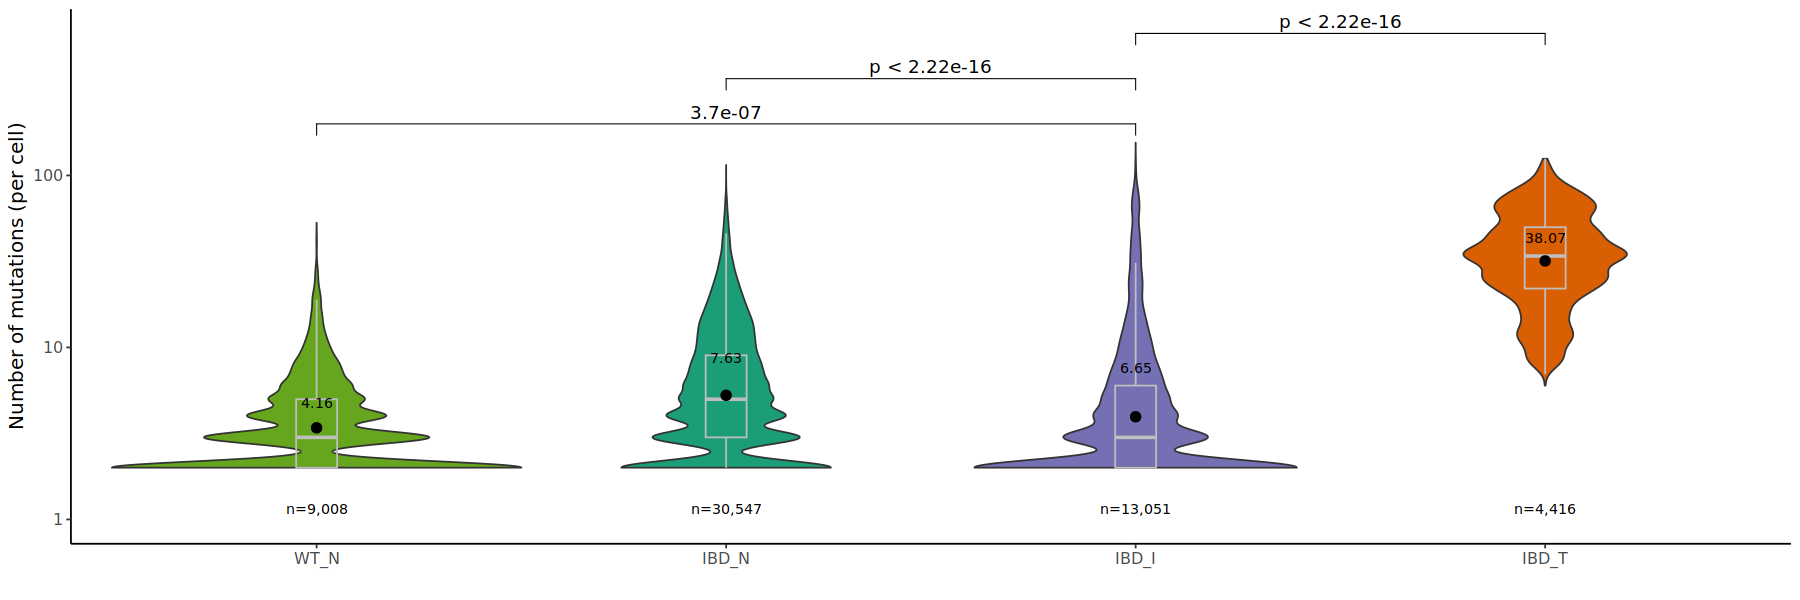

In [24]:
INDIR = "/data2/kantian/LineageTracing/SMALT/0.Results/2.final_phy_re/"
OUTDIR = "/data2/kantian/LineageTracing/SMALT/0.Results/figures/"
# samplelist <- read.delim("F:/SMALT/Results/sample_list_phy_filtered.txt",header = T)
# setDT(samplelist)
# samplelist[, sampleType := paste0(cat, "_",type)]
sampleTypes = c("WT_N","IBD_N","IBD_I","IBD_T")
samplesall = list(c("WT1_N5","WT1_N7","WT2_N3","WT2_N5"),
                  c("2_N","4_N","5_N","16_N","19_N","47_N1","47_N4","47_N5","47_N6","47_N8",
                    "49_N","50_N","65_N","66_N", "17_N","151_N","142_N","148_N"),
                 c("19_T1_I","19_T3_I","19_T4_I","19_T5_I"),
                 c("19_T1","19_T3","19_T4","19_T5"))
dt <- data.table()
for(my.type in 1:length(sampleTypes)){
  # message("Calculating ", my.type, "...")
  subs <- samplesall[[my.type]]
  for(my.sample in subs){
    # message("\tCalculating ", my.sample, "...")
    x <- read.delim(paste0(INDIR,my.sample,"_filtered_re.phy"),header = F, sep = " ",
                    colClasses=c("character","character"),skip = 2,
                    col.names = c("cellID","bi"))
    setDT(x)
    setkey(x, cellID)
    new <- lapply(as.list(x$cellID),function(i){
      temp <- x[.(i)]$bi
      data.table(cellID = i, numMut = str_count(temp,"1"))
    })
    new <- rbindlist(new)
    # print(min(new$numMut))
    new$sample = my.sample
    new$sampleType = sampleTypes[my.type]
    dt <- rbind(dt, new)
  }
}
stats = ddply(dt, .(sampleType, sample), summarize, mouseID=unlist(strsplit(sample[1],"_"))[1],
              sampleID=unlist(strsplit(sample[1],"_"))[2],numCell=length(cellID),
              med = median(numMut),mean = round(mean(numMut),2),min=min(numMut))
##-----------------------------------------
meds <- ddply(dt, .(sampleType), summarize, med = median(numMut),mean = mean(numMut),min=min(numMut))
my_comparisons <- list(c("WT_N","IBD_I"),c("IBD_N","IBD_I"),c("IBD_I","IBD_T"))
dt$sampleType <- factor(dt$sampleType, levels = c("WT_N","IBD_N","IBD_I","IBD_T"))
samplesize = data.table(table(dt$sampleType))
colnames(samplesize) <- c("sampleType","numCell")
##
mycols <- c("#66A61E","#1B9E77","#7570B3","#D95F02","#E7298A") 
p1 <- ggplot(dt, aes(x=sampleType, y=numMut,fill=sampleType))+
  geom_violin(width=1) +
  geom_boxplot(width=0.1,color = "grey",alpha = 0.2, outlier.shape = NA)+
  geom_text(data=meds, aes(y=mean, label = round(mean,2)),size = 3, vjust = -0.5)+
  geom_text(data=samplesize, aes(y=1, label = paste0("n=",scales::comma(numCell))),size = 3, vjust = -0.5)+
  labs(x="", y="Number of mutations (per cell)")+theme_classic()+#ggtitle("")+
  scale_y_log10()+ #ggtitle("All samples")+
  theme(text = element_text(size=12),plot.title = element_text(hjust = 0.5, size = 12),
        legend.position="none")+ #axis.text.x = element_text(angle = 30, vjust = 1, hjust=1),
  stat_compare_means(comparisons = my_comparisons)+
  stat_summary(fun=mean, geom='point', shape=20, size=4)+
  scale_fill_manual(values=mycols)
pdf(file = paste0(OUTDIR,"fig1H.mutation_numbers_comparison_IBDN_IBDI.pdf"), height = 4, width = 4.5)
p1
dev.off()
options(repr.plot.width = 5, repr.plot.height = 5)
p1

png 
  2

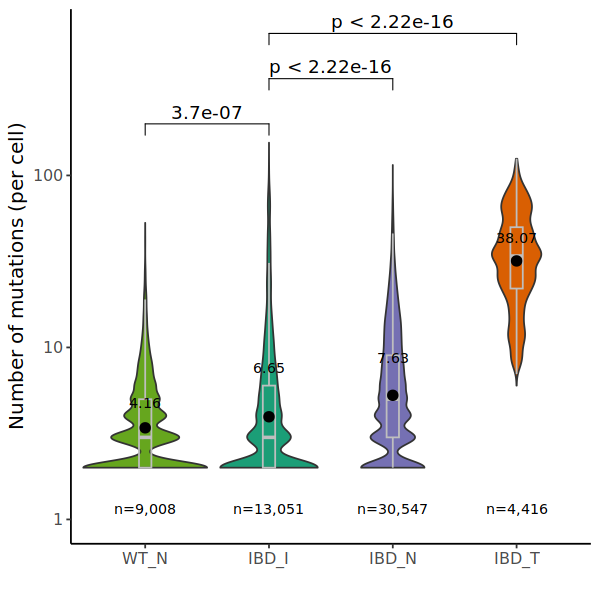

In [27]:
dt$sampleType <- as.character(dt$sampleType)
dt$sampleType <- factor(dt$sampleType, levels = c("WT_N","IBD_I","IBD_N","IBD_T"))
options(repr.plot.width = 5, repr.plot.height = 5)
p1 <- ggplot(dt, aes(x=sampleType, y=numMut,fill=sampleType))+
  geom_violin(width=1) +
  geom_boxplot(width=0.1,color = "grey",alpha = 0.2, outlier.shape = NA)+
  geom_text(data=meds, aes(y=mean, label = round(mean,2)),size = 3, vjust = -0.5)+
  geom_text(data=samplesize, aes(y=1, label = paste0("n=",scales::comma(numCell))),size = 3, vjust = -0.5)+
  labs(x="", y="Number of mutations (per cell)")+theme_classic()+#ggtitle("")+
  scale_y_log10()+ #ggtitle("All samples")+
  theme(text = element_text(size=12),plot.title = element_text(hjust = 0.5, size = 12),
        legend.position="none")+ #axis.text.x = element_text(angle = 30, vjust = 1, hjust=1),
  stat_compare_means(comparisons = my_comparisons)+
  stat_summary(fun=mean, geom='point', shape=20, size=4)+
  scale_fill_manual(values=mycols)
p1
pdf(file = paste0(OUTDIR,"fig1H.mutation_numbers_comparison_IBDN_IBDI.pdf"), height = 4, width = 4.5)
p1
dev.off()


## 3. mutation number comparison -- Monoclonal vs Polyclonal (fig.2e)

Warning message in wilcox.test.default(c(1.34242268082221, 0.602059991327962, 0.778151250383644, :
“cannot compute exact p-value with ties”


png 
  2

Warning message in wilcox.test.default(c(1.34242268082221, 0.602059991327962, 0.778151250383644, :
“cannot compute exact p-value with ties”


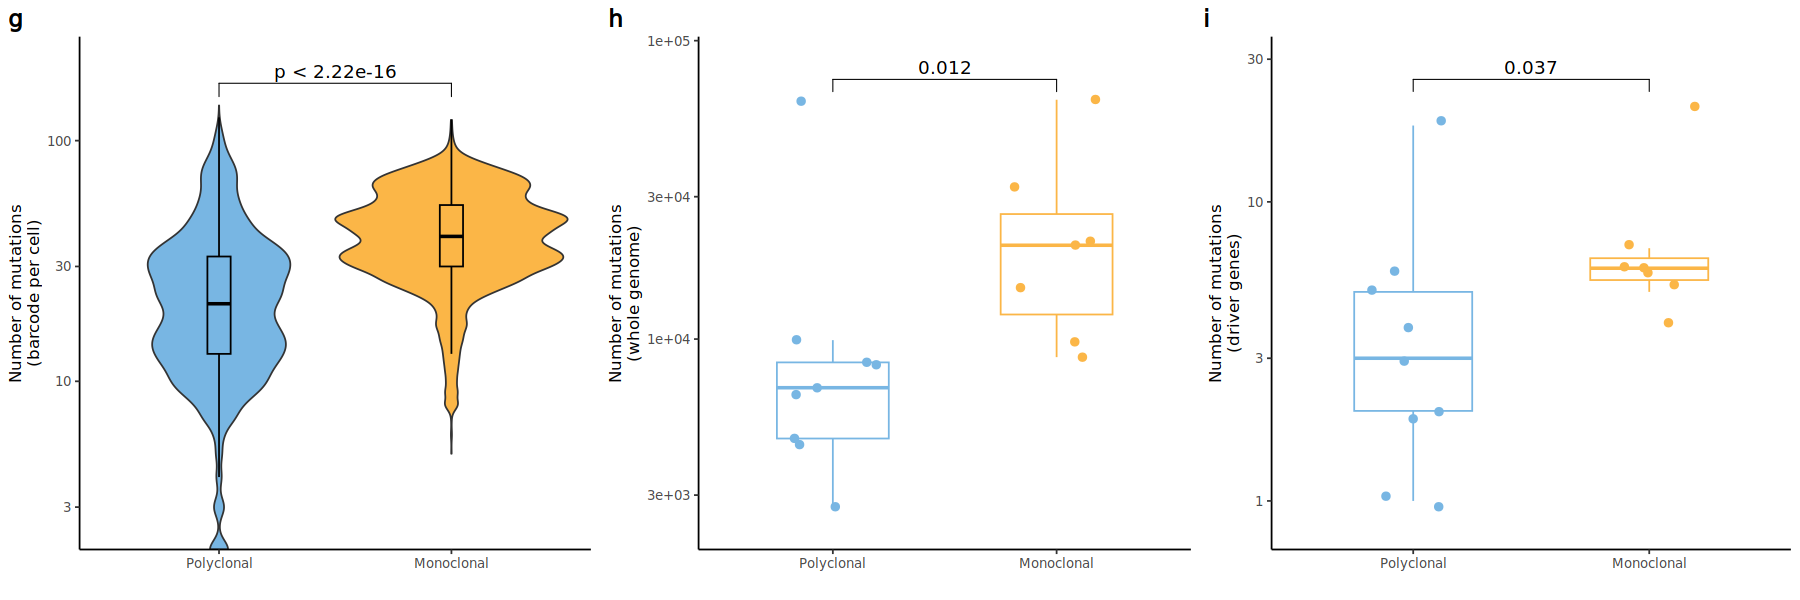

In [54]:
INDIR = "/data2/kantian/LineageTracing/SMALT/0.Results/2.final_phy_re/"
OUTDIR = "/data2/kantian/LineageTracing/SMALT/0.Results/figures/"
#############################################################################################
## mutations in barcode
#############################################################################################
dt <- read.delim(paste0(OUTDIR, "2.1.mutations_per_cell.txt"),header = T)
setDT(dt)
dt <- dt[sampleType =="IBD_T"]
dt[, origin := ifelse(sample %in% c("142_T1","148_T1","16_T","19_T3","4_T","49_T1","49_T3","5_T","65_T1","66_T"), "Monoclonal","Polyclonal")]

meds <- ddply(dt, .(origin), summarize, med = median(numMut),mean = mean(numMut),min=min(numMut))
# my_comparisons <- list(c("Apc_Normal","WT_Normal"),c("Apc_Normal","CRC_Normal"),c("WT_Normal","CRC_Normal"),c("CRC_Tumor","Apc_P"))#,c("Apc_Normal","WT_Normal")
my_comparisons <- list(c("Monoclonal","Polyclonal"))
# dt$sampleType <- factor(dt$sampleType, levels = c("WT_Normal","CRC_Normal","Apc_Normal","CRC_Tumor","Apc_P"))
# dt$sampleType <- factor(dt$sampleType, levels = c("WT_Normal","Apc_Normal","CRC_Normal","Apc_P","CRC_Tumor"))
samplesize = data.table(table(dt$origin))
colnames(samplesize) <- c("origin","numCell")

# cols =c(Monoclonal="#ff7f00",Polyclonal="#377eb8")
# cols =c(Monoclonal="#fb9a99",Polyclonal="#a6cee3")
cols =c(Monoclonal="#fbb647",Polyclonal="#78b6e3")

dt$origin <- factor(dt$origin, levels = c("Polyclonal","Monoclonal"))
# p1 <- ggplot(dt, aes(x=origin, y=numMut,fill=origin))+
#   geom_violin(width=1) +
#   geom_boxplot(width=0.1,color = "black",alpha = 0.2, outlier.shape = NA)+
#   #geom_text(data=meds, aes(y=mean, label = round(mean,2)),size = 3, vjust = -0.5)+
#   geom_text(data=samplesize, aes(y=1, label = paste0("n=",scales::comma(numCell))),size = 3, vjust = -0.5)+
#   labs(x="", y="Number of mutations\n(barcode per cell)",title="")+theme_classic()+#ggtitle("")+
#   scale_y_log10(expand=expansion(mult=c(0,0.1)))+ #ggtitle("All samples")+
#   theme(text = element_text(size=10),plot.title = element_text(hjust = 0.5, size = 12),legend.position="none")+
#   stat_compare_means(comparisons = my_comparisons)+
#   #stat_summary(fun=mean, geom='point', shape=20, size=4)+
#   scale_fill_manual(values=cols)
p1 <- ggplot(dt, aes(x=origin, y=numMut,fill=origin))+
  geom_violin(width=1) +
  geom_boxplot(width=0.1,color = "black",alpha = 0.2, outlier.shape = NA)+
  #geom_text(data=meds, aes(y=mean, label = round(mean,2)),size = 3, vjust = -0.5)+
  #geom_text(data=samplesize, aes(y=1, label = paste0("n=",scales::comma(numCell))),size = 3, vjust = -0.5)+
  labs(x="", y="Number of mutations\n(barcode per cell)",title="")+theme_classic()+#ggtitle("")+
  scale_y_log10(expand=expansion(mult=c(0,0.1)))+ #ggtitle("All samples")+
  theme(text = element_text(size=10),plot.title = element_text(hjust = 0.5, size = 12),legend.position="none")+
  stat_compare_means(comparisons = my_comparisons)+
  #stat_summary(fun=mean, geom='point', shape=20, size=4)+
  scale_fill_manual(values=cols)
#############################################################################################
## mutations in 
#############################################################################################
x <- read.delim("/data2/kantian/LineageTracing/SMALT/0.Results0.99/CRC_TMB.txt")
setDT(x)
x[, origin := ifelse(Tumor_Sample_Barcode %in% c("142_T1","148_T1","16_T","19_T3","4_T","49_T1","49_T3","5_T","65_T1","66_T1"), "Monoclonal","Polyclonal")]
# x <- x[! Tumor_Sample_Barcode %in% c("2_T2","2_T3")]
# x
meds <- ddply(x, .(origin), summarize, med = median(TMB),mean = mean(TMB),min=min(TMB))
# samplesize = data.table(table(x$origin))
# colnames(samplesize) <- c("origin","numCell")
my_comparisons <- list(c("Monoclonal","Polyclonal"))
x$origin <- factor(x$origin, levels = c("Polyclonal","Monoclonal"))
p2 <- ggplot(x, aes(x=origin, y=TMB,color=origin))+
    geom_boxplot(width=0.5,outlier.shape = NA) +
    geom_jitter(width = 0.2,cex=2) +
  labs(x="", y="Number of mutations\n(whole genome)",title="") +
  theme_classic() +
  scale_y_log10(expand=expansion(mult=c(0.1,0.1))) +
  theme(text = element_text(size=10), legend.position="none") +
  stat_compare_means(comparisons = my_comparisons)+
  scale_color_manual(values=cols)
p3 <- ggplot(x, aes(x=origin, y=driver_TMB,color=origin))+
    geom_boxplot(width=0.5,outlier.shape = NA) +
    geom_jitter(width = 0.2,cex=2) +
  labs(x="", y="Number of mutations\n(driver genes)",title="")+
  theme_classic() +
  scale_y_log10(expand=expansion(mult=c(0.1,0.1))) +
  theme(text = element_text(size=10), legend.position="none") +
  stat_compare_means(comparisons = my_comparisons)+
  scale_color_manual(values=cols)
pdf(file = paste0(OUTDIR,"fig2de.mutation_numbers_comparison_TMB_mono_poly.pdf"), height = 3, width = 7)
ggarrange(p1,p2,p3, labels =c("g","h","i"),ncol=3)
dev.off()
options(repr.plot.width = 15, repr.plot.height = 5)
ggarrange(p1,p2,p3, labels =c("g","h","i"),ncol=3)


In [27]:
x <- read.delim("/data2/kantian/LineageTracing/SMALT/0.Results0.99/CRC_TMB.txt")
setDT(x)
x[, origin := ifelse(Tumor_Sample_Barcode %in% c("142_T1","148_T1","16_T","19_T3","4_T","49_T1","49_T3","5_T","65_T1","66_T1"), "Monoclonal","Polyclonal")]
x

Tumor_Sample_Barcode,TMB,coding_TMB,driver_coding_TMB,driver_TMB,driver_num,Sample_classification,Clonality,Classfication,origin
<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
16_T,63391,694,22,22,20,CRC,Monoclonal,Monoclonal,Monoclonal
2_T2,4442,35,1,1,1,CRC,Polyclonal,Polyclonal,Polyclonal
2_T3,2742,23,1,1,1,CRC,Polyclonal,Polyclonal,Polyclonal
47_T1,6517,57,4,4,4,CRC,Monoclonal,Monoclonal,Polyclonal
47_T4,6870,63,3,3,3,CRC,Polyclonal,Polyclonal,Polyclonal
47_T5,8212,60,2,2,2,CRC,Polyclonal,Polyclonal,Polyclonal
47_T6,62836,613,18,18,18,CRC,Polyclonal,Polyclonal,Polyclonal
47_T8,8352,102,5,5,5,CRC,Polyclonal,Polyclonal,Polyclonal
49_T1,21351,160,4,4,4,CRC,Monoclonal,Monoclonal,Monoclonal


In [62]:
x <- x[Tumor_Sample_Barcode !%in% c("2_T2","2_T3")]
x

ERROR: Error in parse(text = x, srcfile = src): <text>:1:29: unexpected '!'
1: x <- x[Tumor_Sample_Barcode !
                                ^


In [209]:
wilcox.test(x[origin=="Monoclonal",TMB],x[origin=="Polyclonal",TMB],paired=FALSE)


	Wilcoxon rank sum exact test

data:  x[origin == "Monoclonal", TMB] and x[origin == "Polyclonal", TMB]
W = 53, p-value = 0.01099
alternative hypothesis: true location shift is not equal to 0


## 4. mutation type frequency (fig1F, 1E) (ignore 142&148, because of 3k break)

In [57]:
library(Biostrings)
library(stringr)
library(ggpubr)
library(dplyr)
library(data.table)
library(ggplot2)
################################################################################
sampleTypes = c("WT_N","Apc_N","IBD_N","Apc_P","IBD_T")
samplesall = list(c("WT1_N5","WT1_N7","WT2_N3","WT2_N5"),
                  c("68_N","72_N","71_N","75_N"),
                  c("2_N","4_N","5_N","16_N","19_N","47_N1","47_N4","47_N5","47_N6","47_N8",
                    "49_N","50_N","65_N","66_N", "17_N","151_N","142_N","148_N"),#"132_N","18_N"
                  c("68_P1","68_P2","68_P3","68_P4","68_P5-1","68_P5-2","68_P5-3",
                    "68_P5-4","68_P5-5","72_P1","72_P2","72_P4","72_P5","72_P6","72_P8","72_P9",
                    "71_P3","75_P3","75_P5","75_P8","75_P11"),
                  c("2_T2","2_T3","4_T","5_T","16_T","47_T1","47_T4","47_T5","47_T6","47_T8",
                    "49_T1","49_T3","50_T","65_T1","65_T3","66_T","19_T1","19_T3","19_T4","19_T5",
                    "132_T1","151_T4","17_T4","18_T3","18_T4","142_T1","142_T2","142_T5-4","148_T1","148_T3")
                  )

PHYDIR = "/data2/kantian/LineageTracing/SMALT/0.Results/2.final_phy_re/"
FADIR = "/data2/kantian/LineageTracing/SMALT/0.Results0.99/0.5.consensus0.99/"
OUTDIR = "/data2/kantian/LineageTracing/SMALT/0.Results/figures/"
##
refa <- readDNAStringSet("/data2/kantian//LineageTracing/SMALT/reference/3k_HMFonly.fasta")
ref <- read.delim("/data2/kantian/LineageTracing/SMALT/reference/3K_coordinate3004.txt",
                    header = T)
setDT(ref)
colnames(ref)[2:3] <- c("start","end")


In [58]:
samplesall = list(c("WT1_N5","WT1_N7","WT2_N3","WT2_N5"),
                  c("68_N","72_N","71_N","75_N"),
                  c("2_N","4_N","5_N","16_N","19_N","47_N1","47_N4","47_N5","47_N6","47_N8",
                    "49_N","50_N","65_N","66_N", "17_N","151_N"),#"132_N","18_N",,"142_N","148_N"
                  c("68_P1","68_P2","68_P3","68_P4","68_P5-1","68_P5-2","68_P5-3",
                    "68_P5-4","68_P5-5","72_P1","72_P2","72_P4","72_P5","72_P6","72_P8","72_P9",
                    "71_P3","75_P3","75_P5","75_P8","75_P11"),
                  c("2_T2","2_T3","4_T","5_T","16_T","47_T1","47_T4","47_T5","47_T6","47_T8",
                    "49_T1","49_T3","50_T","65_T1","65_T3","66_T","19_T1","19_T3","19_T4","19_T5",
                    "132_T1","151_T4","17_T4","18_T3","18_T4")#,"142_T1","142_T2","142_T5-4","148_T1","148_T3"
                  )
samplesall_fa = list(c("WT1_N5","WT1_N7","WT2_N3","WT2_N5"),
                  c("68_N","72_N","71_N3","75_N8"),
                  c("2_N","4_N","5_N","16_N","19_N_E","47_N1","47_N4","47_N5","47_N6","47_N8",
                    "49_N","50_N","65_N","66_N1", "17_N","151_N","142_N","148_N"),
                  c("68_P1","68_P2","68_P3","68_P4","68_P5-1","68_P5-2","68_P5-3",
                    "68_P5-4","68_P5-5","72_P1","72_P2","72_P4","72_P5","72_P6","72_T8","72_T9",
                    "71_P3","75_P3","75_P5","75_P8","75_P11"),
                  c("2_T2","2_T3","4_T","5_T","16_T","47_T1","47_T4","47_T5","47_T6","47_T8",#
                    "49_T1","49_T3","50_T","65_T1","65_T3","66_T1","19_T1_E","19_T3_E","19_T4_E","19_T5_E",
                   "132_T1","151_T4","17_T4","18_T3","18_T4")#,"142_T1","142_T2","142_T5-4","148_T1","148_T3"
                  )
df <- data.table()
numCell <- data.table()
cellMutCount <- data.table()
for(my.type in 1:length(sampleTypes)){
  samples = samplesall[[my.type]]
        subs_fa <- samplesall_fa[[my.type]]

  for(my.sample in 1:length(samples)){
    message("Calculating ", samples[my.sample], "...")
    fa <- readDNAStringSet(paste0(FADIR,subs_fa[my.sample],"_3_0.6.fa"))
    # # fa <- fa[names(fa) != "ref"]
    phy <- read.table(paste0(PHYDIR,samples[my.sample], "_filtered_re.phy"),header = F, sep = " ",
                      colClasses=c("character","character"),skip = 2,
                      col.names = c("cellID","bi"))
    setDT(phy)
    setkey(phy, cellID)
    new <- lapply(as.list(phy$cellID),function(i){
      temp <- phy[.(i)]$bi
      s = str_split(temp,"")[[1]]
      data.table(cellID = i, pos=which(s=="1"))
    })
    new <- rbindlist(new)
    newCount <- new[,.(count=.N),by=cellID]
    newCount[, sample := samples[my.sample]]
    newCount[, sampleType := sampleTypes[my.type]]
    cellMutCount <- rbind(cellMutCount, newCount)

    numCell <- rbind(numCell, data.table(sampleType = sampleTypes[my.type],
                                         sample = samples[my.sample], 
                                         numCell = nrow(newCount),
                                         meanMut = mean(newCount$count),
                                         medianMut = median(newCount$count)))
    mut_type <- lapply(as.list(unique(new$cellID)),function(i){
      s <- new[cellID ==i,pos]
      name_ori = strsplit(i,"_")[[1]][2]
      data.table(cellID = i,pos = s, ref = strsplit(paste(refa),"")[[1]][s],
                 nuc = strsplit(paste(fa[name_ori]),"")[[1]][s])
    })
    mut_type <- rbindlist(mut_type)
    mut_type[, mut := paste0(ref,"->",nuc)]
    
    df2 <- data.table()
    for(i in 1:nrow(ref)){
      if(ref$direction[i] == "forward"){
        selected = (ref$end[i]-80):(ref$end[i]+80)
        temp <- mut_type[mut_type$pos %in% selected]
        temp$dis <- temp$pos - ref$end[i]
      }else{
        selected = (ref$start[i]-80):(ref$start[i]+80)
        temp <- mut_type[mut_type$pos %in% selected]
        temp$dis <- ref$start[i] - temp$pos
      }
      # temp$id <- ref$ID[i]
      df2 <- rbind(df2,temp)
    }
    ## mutate mutation types
    df3 <- df2 %>%
      mutate(m = case_when(mut == "A->C" ~ "T->G",
                           mut == "A->G" ~ "T->C",
                           mut == "A->T" ~ "T->A",
                           mut == "G->A" ~ "C->T",
                           mut == "G->C" ~ "C->G",
                           mut == "G->T" ~ "C->A",
                           TRUE ~ as.character(mut))
      )
    df3 <- df3 %>%
      mutate(m = case_when(m == "T->G" ~ "T/A->G/C",
                           m == "T->C" ~ "T/A->C/G",
                           m == "T->A" ~ "T/A->A/T",
                           m == "C->T" ~ "C/G->T/A",
                           m == "C->G" ~ "C/G->G/C",
                           m == "C->A" ~ "C/G->A/T",
                           TRUE ~ as.character(m))
      )

    df3$sample = samples[my.sample]
    df3$sampleType = sampleTypes[my.type]
    df3[, mouseID:= str_extract(sample, "[0-9]+")]
    # df3[, direction:= ifelse(id %in% c("iSceI1","iSceI3","iSceI5","iSceI7","iSceI9",
    #                                    "iSceI11","iSceI13","iSceI15"), "backward", "forward")]
    df <- rbind(df, df3)
  }
}


Calculating WT1_N5...

Calculating WT1_N7...

Calculating WT2_N3...

Calculating WT2_N5...

Calculating 68_N...

Calculating 72_N...

Calculating 71_N...

Calculating 75_N...

Calculating 2_N...

Calculating 4_N...

Calculating 5_N...

Calculating 16_N...

Calculating 19_N...

Calculating 47_N1...

Calculating 47_N4...

Calculating 47_N5...

Calculating 47_N6...

Calculating 47_N8...

Calculating 49_N...

Calculating 50_N...

Calculating 65_N...

Calculating 66_N...

Calculating 17_N...

Calculating 151_N...

Calculating 68_Ade1...

Calculating 68_Ade2...

Calculating 68_Ade3...

Calculating 68_Ade4...

Calculating 68_Ade5-1...

Calculating 68_Ade5-2...

Calculating 68_Ade5-3...

Calculating 68_Ade5-4...

Calculating 68_Ade5-5...

Calculating 72_Ade1...

Calculating 72_Ade2...

Calculating 72_Ade4...

Calculating 72_Ade5...

Calculating 72_Ade6...

Calculating 72_Ade8...

Calculating 72_Ade9...

Calculating 71_Ade3...

Calculating 75_Ade3...

Calculating 75_Ade5...

Calculating 75_Ade8

png 
  2

png 
  2

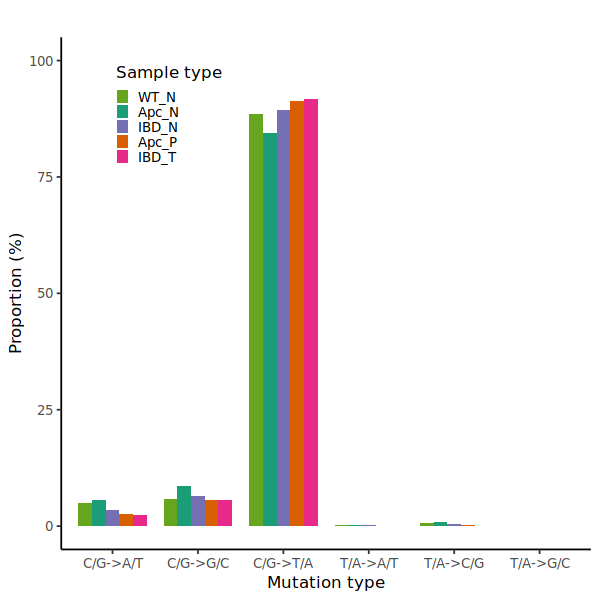

In [78]:
df[, num:= 1]
dt <- df[, as.integer(sum(num)), by = list(m, sampleType)]
colnames(dt)[ncol(dt)] <- "sum"
dt[, ref:= substr(m, 1,1)]
temp <-  dt[,.(mutSite=sum(sum)),by=sampleType]
dt <- merge(dt, temp, by="sampleType")
dt[, freq := round(sum/mutSite*100,2)]
##--------------change 6/22/2023 start-----------------
# dt[, sampleType:= ifelse(sampleType =="IBD_N","IBD_Normal",
#                          ifelse(sampleType == "IBD_T","IBD_Tumor", sampleType))]
dt$sampleType <- factor(dt$sampleType, levels = c("WT_N","Apc_N","IBD_N","Apc_P","IBD_T"))
# dt$sampleType <- factor(dt$sampleType, levels = c("WT_N","Apc_N","IBD_N","Apc_Polyp","IBD_T"))
##--------------change 6/22/2023 end-------------------
p <- ggplot(dt, aes(x=m, y=freq, fill = sampleType))+geom_bar(stat="identity",position="dodge", width=0.8)+
  scale_fill_manual(values=mycols)+
  theme_classic()+#facet_wrap(~mouseID, scales = "free_y")+
  ggtitle("")+xlab("Mutation type")+ylab("Proportion (%)")+
  theme(strip.background = element_blank(), legend.key.size = unit(0.3,"cm"), 
        plot.title = element_text(hjust=0.5),text = element_text(size=10),
        legend.position = c(0.2,0.85))+ylim(0,100)+
  guides(fill=guide_legend(title="Sample type"))
pdf(file = paste0(OUTDIR,"fig1F.BS80mutation_mutation_type_proportion.pdf"), width=4, height = 3.5)
print(p)
dev.off()
##------------------------------------------------------------------------------
df1 <- data.table(table(df$m))
df1[, perc := round(N/sum(df1$N),4)]
s1 <- round(df1[V1 == "C/G->T/A",perc]*100,2)
s2 <- round(df1[V1 == "C/G->G/C",perc]*100,2)
s3 <- 100- s1 - s2
pdf(file = paste0(OUTDIR,"fig1F.BS80mutation_type_percentage.pdf"), width=4, height = 3.5)
pie(c(s1,s2,s3),labels=paste(c("C/G->T/A\n","\nC/G->G/C\n","Others "),
                             c(paste0(s1,"%"),paste0(s2,"%"),paste0(s3,"%"))),
    col = c("#fbb4ae", "#b3cde3", "#ccebc5"),cex=0.75)
dev.off()
options(repr.plot.width = 5, repr.plot.height = 5)
p

png 
  2

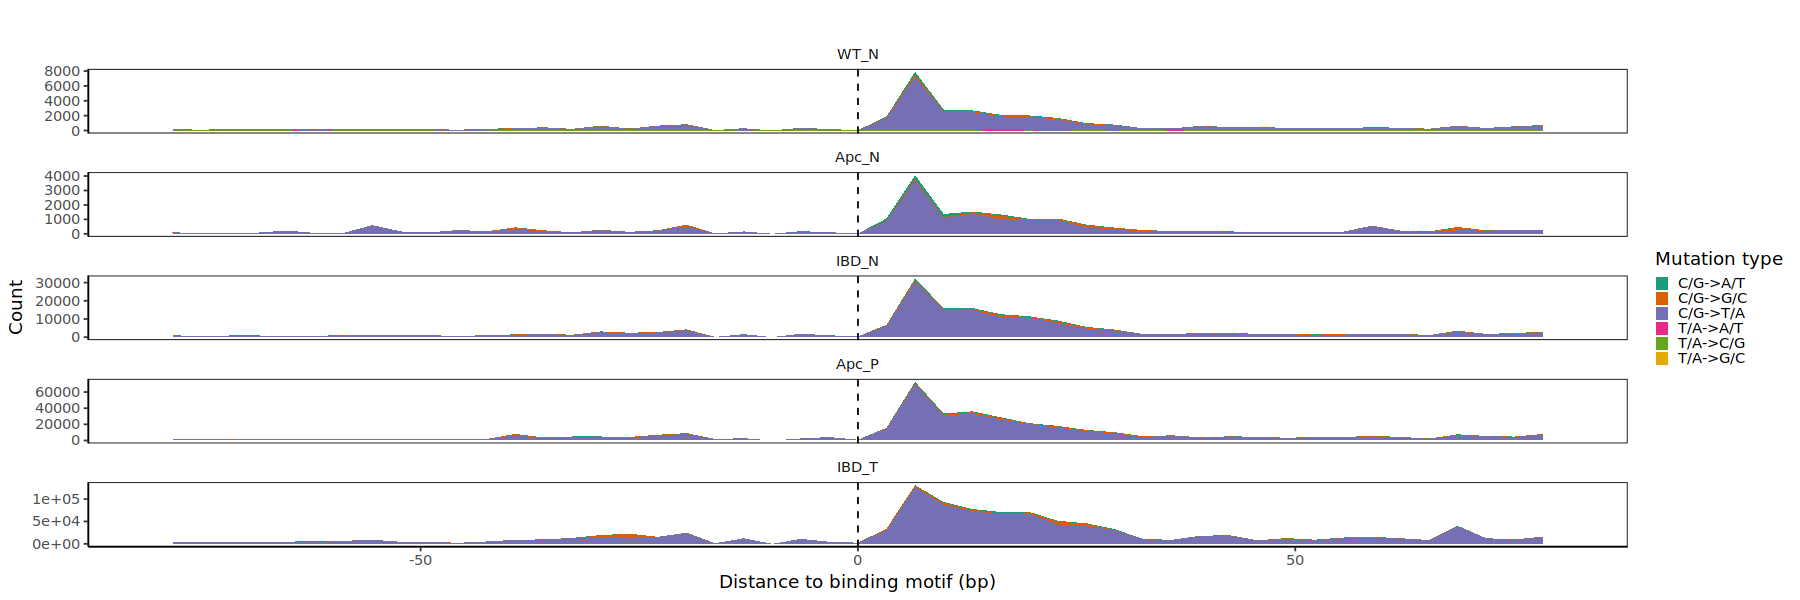

In [59]:
df[, num:= 1]
dt <- df[, as.integer(sum(num)), by = list(m, sampleType)]
colnames(dt)[ncol(dt)] <- "sum"
dt[, ref:= substr(m, 1,1)]
temp <-  dt[,.(mutSite=sum(sum)),by=sampleType]
dt <- merge(dt, temp, by="sampleType")
dt[, freq := round(sum/mutSite*100,2)]
##--------------change 6/22/2023 start-----------------
# dt[, sampleType:= ifelse(sampleType =="IBD_N","IBD_Normal",
#                          ifelse(sampleType == "IBD_T","IBD_Tumor", sampleType))]
dt$sampleType <- factor(dt$sampleType, levels = c("WT_N","Apc_N","IBD_N","Apc_P","IBD_T"))
# dt$sampleType <- factor(dt$sampleType, levels = c("WT_N","Apc_N","IBD_N","Apc_Polyp","IBD_T"))
##--------------change 6/22/2023 end-------------------
p <- ggplot(dt, aes(x=m, y=freq, fill = sampleType))+geom_bar(stat="identity",position="dodge", width=0.8)+
  # scale_fill_brewer(palette="Dark2")+
scale_fill_manual(values=mycols)+
  theme_classic()+#facet_wrap(~mouseID, scales = "free_y")+
  ggtitle("")+xlab("Mutation type")+ylab("Proportion (%)")+
  theme(strip.background = element_blank(), legend.key.size = unit(0.3,"cm"), 
        plot.title = element_text(hjust=0.5),text = element_text(size=10),
        legend.position = c(0.2,0.85))+ylim(0,100)+
  guides(fill=guide_legend(title="Sample type"))
# pdf(file = paste0(OUTDIR,"fig1F.BS80mutation_mutation_type_proportion.pdf"), width=4, height = 3.5)
# print(p)
# dev.off()
##------------------------------------------------------------------------------
df1 <- data.table(table(df$m))
df1[, perc := round(N/sum(df1$N),4)]
s1 <- round(df1[V1 == "C/G->T/A",perc]*100,2)
s2 <- round(df1[V1 == "C/G->G/C",perc]*100,2)
s3 <- 100- s1 - s2
# pdf(file = paste0(OUTDIR,"fig1F.BS80mutation_type_percentage.pdf"), width=4, height = 3.5)
# pie(c(s1,s2,s3),labels=paste(c("C/G->T/A\n","\nC/G->G/C\n","Others "),
#                              c(paste0(s1,"%"),paste0(s2,"%"),paste0(s3,"%"))),
#     col = c("#fbb4ae", "#b3cde3", "#ccebc5"),cex=0.75)
# dev.off()
##------------------------------------------------------------------------------
##------z------------------------------------------------------------------------
df$sampleType <- factor(df$sampleType, levels = c('WT_N','Apc_N','IBD_N','Apc_P','IBD_T'))#,

p2 <- ggplot(df, aes(x=dis, fill = m))+geom_area(stat="bin",bins=50)+
  scale_fill_brewer(palette="Dark2")+
facet_wrap(~sampleType,ncol=1, scale="free_y")+
  #scale_fill_manual(values=mycols)+
  theme_classic()+#facet_wrap(~mouseID, scales = "free_y")+
  ggtitle("")+xlab("Distance to binding motif (bp)")+ylab("Count")+
  theme(strip.background = element_blank(), legend.key.size = unit(0.3,"cm"),
       panel.border=element_rect(colour="black",fill=NA))+
  guides(fill=guide_legend(title="Mutation type"))+
  geom_vline(xintercept = 0, color = "black",linetype = "dashed") 
pdf(file = paste0(OUTDIR,"fig1E.BS80mutation_type_by_sampleType.pdf"), width=6, height = 6)
p2
dev.off()
p2

png 
  2

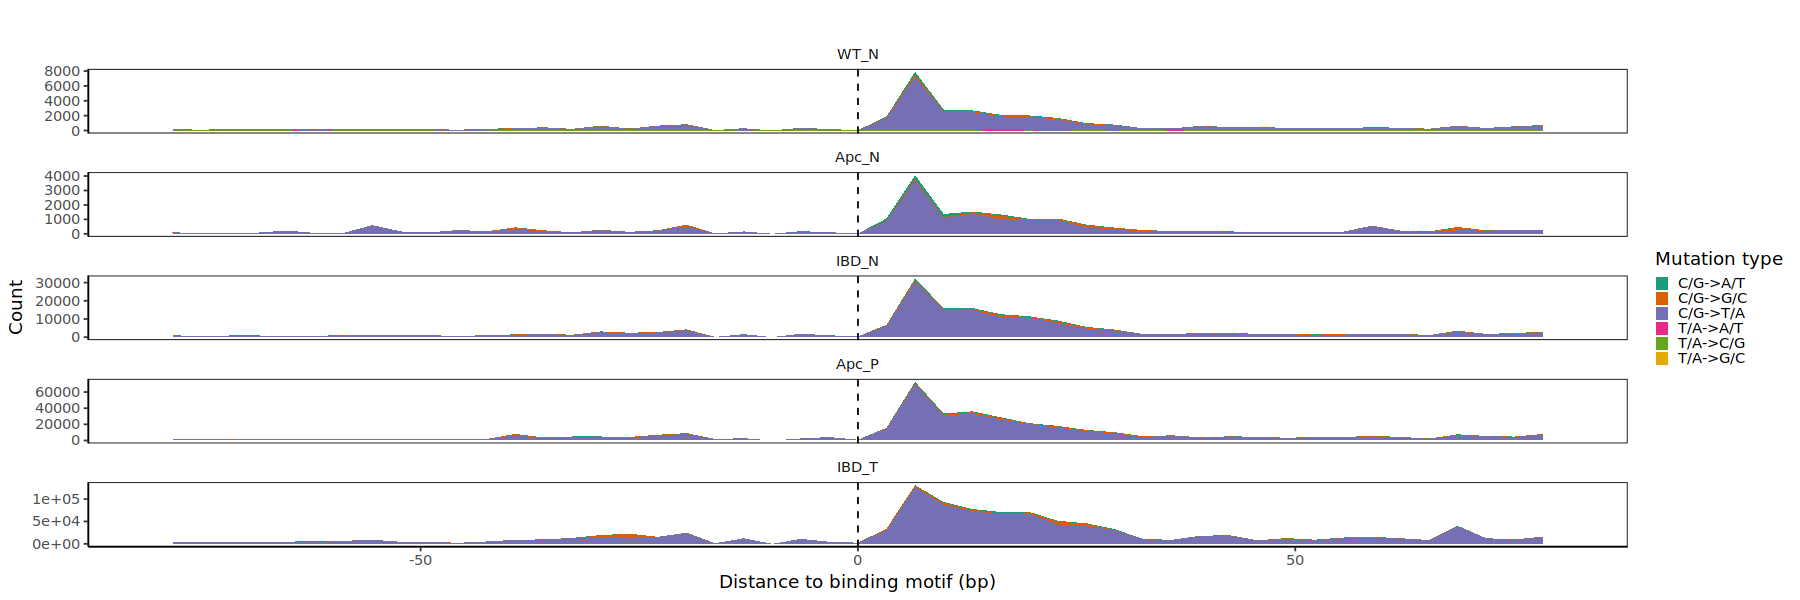

In [60]:
p2 <- ggplot(df, aes(x=dis, fill = m))+geom_area(stat="bin",bins=50)+
  scale_fill_brewer(palette="Dark2")+
facet_wrap(~sampleType,ncol=1, scale="free_y")+
  #scale_fill_manual(values=mycols)+
  theme_classic()+#facet_wrap(~mouseID, scales = "free_y")+
  ggtitle("")+xlab("Distance to binding motif (bp)")+ylab("Count")+
  theme(strip.background = element_blank(), legend.key.size = unit(0.3,"cm"),
       panel.border=element_rect(colour="black",fill=NA))+
  guides(fill=guide_legend(title="Mutation type"))+
  geom_vline(xintercept = 0, color = "black",linetype = "dashed") 
pdf(file = paste0(OUTDIR,"fig1E.BS80mutation_type_by_sampleType.pdf"), width=6, height = 6)
p2
dev.off()
p2

In [55]:
df[1:3,]

pos,numMut,freq,sample,sampleType
<chr>,<int>,<dbl>,<chr>,<chr>
4,2,0.0015797788,WT1_N5,WT_N
7,1,0.0007898894,WT1_N5,WT_N
28,1,0.0007898894,WT1_N5,WT_N


## 5. fig1c.3K_mutation_distribution_frequency_density (ignore 142&148, because of 3k break)

In [28]:
## label binding sites region
PHYDIR = "/data2/kantian/LineageTracing/SMALT/0.Results/2.final_phy_re/"
OUTDIR = "/data2/kantian/LineageTracing/SMALT/0.Results/figures/"
setwd(PHYDIR)
refDF <- read.delim("/data2/kantian/LineageTracing/SMALT/reference/3K_coordinate3004.txt",
                    header = T)
setDT(refDF)
refDF[, start:= ifelse(direction == "forward", X3004 + 1, X1 - 80)]
refDF[, end:= ifelse(direction == "forward", X3004 + 80, X1 - 1)]

sampleTypes = c("WT_N","Apc_N","IBD_N","Apc_P","IBD_T")
samplesall = list(c("WT1_N5","WT1_N7","WT2_N3","WT2_N5"),
                  c("68_N","72_N","71_N","75_N"),
                  c("2_N","4_N","5_N","16_N","19_N","47_N1","47_N4","47_N5","47_N6","47_N8",
                    "49_N","50_N","65_N","66_N", "17_N","151_N"),#"132_N","18_N",,"142_N","148_N"
                  c("68_P1","68_P2","68_P3","68_P4","68_P5-1","68_P5-2","68_P5-3",
                    "68_P5-4","68_P5-5","72_P1","72_P2","72_P4","72_P5","72_P6","72_P8","72_P9",
                    "71_P3","75_P3","75_P5","75_P8","75_P11"),
                  c("2_T2","2_T3","4_T","5_T","16_T","47_T1","47_T4","47_T5","47_T6","47_T8",
                    "49_T1","49_T3","50_T","65_T1","65_T3","66_T","19_T1","19_T3","19_T4","19_T5",
                    "132_T1","151_T4","17_T4","18_T3","18_T4") #,"142_T1","142_T2","142_T5-4","148_T1","148_T3"
                  )

################################################################################
## 1. geom_bar aes(x=pos,y=numMut) by samples
## 1. geom_bar aes(x=pos,y=numMut) by samples
df <- data.table()
for(my.type in 1:5){
  samples = samplesall[[my.type]]
  for(my.sample in samples){
    # message("Calculating ", my.sample, "...")
    x <- read.delim(paste0(my.sample,"_filtered_re.phy"),header = F, sep = " ",
                    colClasses=c("character","character"),skip = 2,
                    col.names = c("cellID","bi"))
    # print(nrow(x))
    if(nrow(x)>0){
      new <- sapply(as.list(1:nrow(x)),function(i){
        s <- x$bi[i]
        which(strsplit(s,"")[[1]]=="1")
      })
      new <- unlist(new)
      d <- data.table(table(new))
      colnames(d) <-c("pos","numMut")
      d[, freq := numMut/nrow(x)]
      d[, sample := my.sample]
      d[,sampleType:= sampleTypes[my.type]]
      df <- rbind(df, d)
    }
  }
}
df$mouseID <- sapply(strsplit(df$sample, split = "_"), `[`, 1)
df$mouseID <- as.character(df$mouseID)
df$pos <- as.numeric(df$pos)
# df=df[pos != 2674 & pos != 2605]


In [30]:
df[,mouse:=ifelse(mouseID %in% c("2","4","5","16","17","18","19","47","49","50","65","66","132","151"), 
                     paste0("IBD",mouseID),
                     ifelse(mouseID %in% c("68","71","72","75"),paste0("Apc",mouseID),mouseID))]

In [31]:
df$mouse <- factor(df$mouse, levels = c("WT1","WT2","IBD2","IBD4","IBD5","IBD16","IBD17","IBD18","IBD19","IBD47","IBD49","IBD50","IBD65","IBD66","IBD132","IBD151","Apc68","Apc71","Apc72","Apc75"))#,


In [23]:
table(df$mouse)


   WT1    WT2   IBD2   IBD4   IBD5  IBD16  IBD17  IBD18  IBD19  IBD47  IBD49 
  1839   2481   1016   2329   2632   2661    342    718   5092   9351   1846 
 IBD50  IBD65  IBD66 IBD132 IBD151  Apc68  Apc71  Apc72  Apc75 
  1899   1204   1914   1247    448   7513   1956  10100   3570 

In [20]:
unique(df$mouse)

[1] "WT1"    "WT2"    "Apc68"  "Apc72"  "Apc71"  "Apc75"  "IDB2"   "IDB4"  
 [9] "IDB5"   "IDB16"  "IDB19"  "IDB47"  "IDB49"  "IDB50"  "IDB65"  "IDB66" 
[17] "IDB17"  "IDB151" "IDB132" "IDB18"

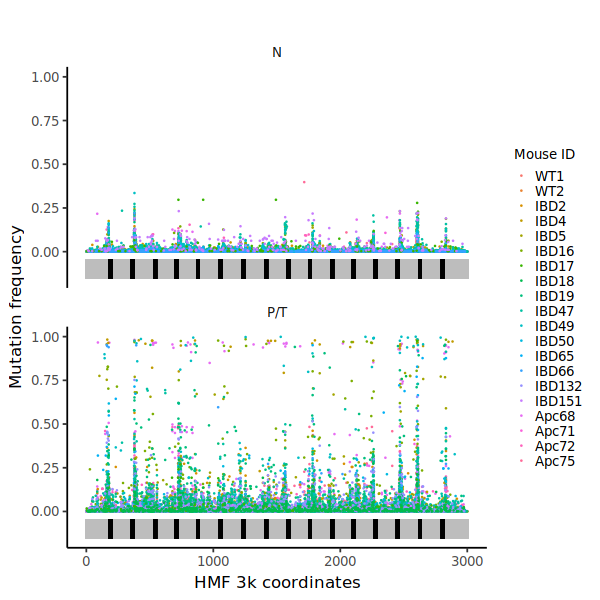

In [32]:
df$sampleType <- factor(df$sampleType, levels = c('WT_N','Apc_N','IBD_N','Apc_P','IBD_T'))#,
df[, cat:= ifelse(sampleType %in% c("WT_N","Apc_N","IBD_N"),"N","P/T")]
p1 <- ggplot(df, aes(x=pos,y=freq,color = mouse))+
  geom_point(size=0.1)+scale_size_continuous(range = c(0.01,1.5))+
  facet_wrap(~cat, ncol=1)+theme_classic()+xlim(0,3004)+
  ggtitle("")+xlab("HMF 3k coordinates")+ylab("Mutation frequency")+
  theme(strip.background = element_blank(), legend.key.size = unit(0.3,"cm"),
        text = element_text(size=10),legend.title=element_text(size=8),
        legend.text = element_text(size = 8))+
  labs(size="Mutation\nfrequency", colour="Mouse ID")
p1 <- p1+geom_rect(data = NULL, aes(xmin=0,xmax = 3004,ymin=-0.15, ymax=-0.05), fill = "#bdbdbd",color = "#bdbdbd")
p1 <- p1+geom_rect(data = NULL, aes(xmin=refDF[1,X1],xmax = refDF[1,X3004],ymin=-0.15, ymax=-0.05), fill = "black",color = "black")
p1 <- p1+geom_rect(data = NULL, aes(xmin=refDF[2,X1],xmax = refDF[2,X3004],ymin=-0.15, ymax=-0.05), fill = "black",color = "black")
p1 <- p1+geom_rect(data = NULL, aes(xmin=refDF[3,X1],xmax = refDF[3,X3004],ymin=-0.15, ymax=-0.05), fill = "black",color = "black")
p1 <- p1+geom_rect(data = NULL, aes(xmin=refDF[4,X1],xmax = refDF[4,X3004],ymin=-0.15, ymax=-0.05), fill = "black",color = "black")
p1 <- p1+geom_rect(data = NULL, aes(xmin=refDF[5,X1],xmax = refDF[5,X3004],ymin=-0.15, ymax=-0.05), fill = "black",color = "black")
p1 <- p1+geom_rect(data = NULL, aes(xmin=refDF[6,X1],xmax = refDF[6,X3004],ymin=-0.15, ymax=-0.05), fill = "black",color = "black")
p1 <- p1+geom_rect(data = NULL, aes(xmin=refDF[7,X1],xmax = refDF[7,X3004],ymin=-0.15, ymax=-0.05), fill = "black",color = "black")
p1 <- p1+geom_rect(data = NULL, aes(xmin=refDF[8,X1],xmax = refDF[8,X3004],ymin=-0.15, ymax=-0.05), fill = "black",color = "black")
p1 <- p1+geom_rect(data = NULL, aes(xmin=refDF[9,X1],xmax = refDF[9,X3004],ymin=-0.15, ymax=-0.05), fill = "black",color = "black")
p1 <- p1+geom_rect(data = NULL, aes(xmin=refDF[10,X1],xmax = refDF[10,X3004],ymin=-0.15, ymax=-0.05), fill = "black",color = "black")
p1 <- p1+geom_rect(data = NULL, aes(xmin=refDF[11,X1],xmax = refDF[11,X3004],ymin=-0.15, ymax=-0.05), fill = "black",color = "black")
p1 <- p1+geom_rect(data = NULL, aes(xmin=refDF[12,X1],xmax = refDF[12,X3004],ymin=-0.15, ymax=-0.05), fill = "black",color = "black")
p1 <- p1+geom_rect(data = NULL, aes(xmin=refDF[13,X1],xmax = refDF[13,X3004],ymin=-0.15, ymax=-0.05), fill = "black",color = "black")
p1 <- p1+geom_rect(data = NULL, aes(xmin=refDF[14,X1],xmax = refDF[14,X3004],ymin=-0.15, ymax=-0.05), fill = "black",color = "black")
p1 <- p1+geom_rect(data = NULL, aes(xmin=refDF[15,X1],xmax = refDF[15,X3004],ymin=-0.15, ymax=-0.05), fill = "black",color = "black")
p1 <- p1+geom_rect(data = NULL, aes(xmin=refDF[16,X1],xmax = refDF[16,X3004],ymin=-0.15, ymax=-0.05), fill = "black",color = "black")
p1
# pdf(file = paste0(OUTDIR,"fig1D.3K_mutation_distribution_frequency_density.pdf"), width=5, height = 3)
# p1
# dev.off()
  

In [ ]:
ggsave(file = paste0(OUTDIR,"fig1D.3K_mutation_distribution_frequency_density.png"), width=5, height = 3,dpi=1200)
p1
dev.off()


png 
  2

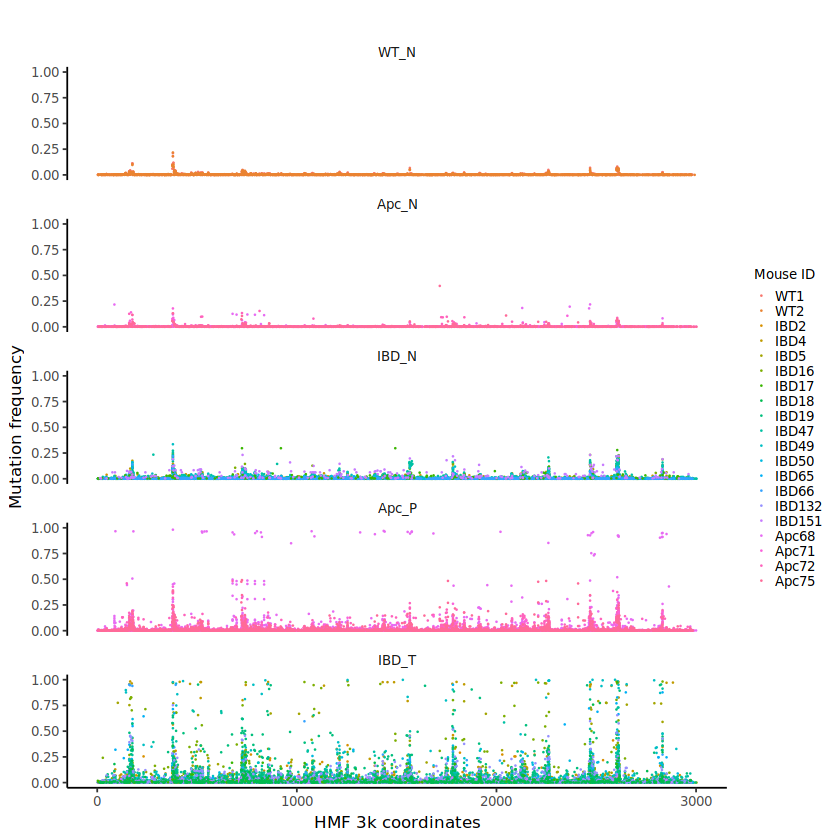

In [26]:

p3 <- ggplot(df, aes(x=pos,y=freq,color = mouse))+
  geom_point(size=0.1)+scale_size_continuous(range = c(0.01,1.5))+
  facet_wrap(~sampleType, ncol=1,scale="free_y")+theme_classic()+xlim(0,3004)+ylim(0,1)+
  ggtitle("")+xlab("HMF 3k coordinates")+ylab("Mutation frequency")+
  theme(strip.background = element_blank(), legend.key.size = unit(0.3,"cm"),
        text = element_text(size=10),legend.title=element_text(size=8),
        legend.text = element_text(size = 8))+
  labs(size="Mutation\nfrequency", colour="Mouse ID")
pdf(file = paste0(OUTDIR,"fig1c_S.3K_mutation_distribution_frequency_supplementary.pdf"), width=4, height = 6)
p3
# p2 +heme(text = element_text(size=10))
dev.off()
p3

## Supplementary -- hotspot analysis

Calculating WT_N...

Calculating WT1_N5...

Calculating WT1_N7...

Calculating WT2_N3...

Calculating WT2_N5...



[1] 14

[1] 24.21924

png 
  2

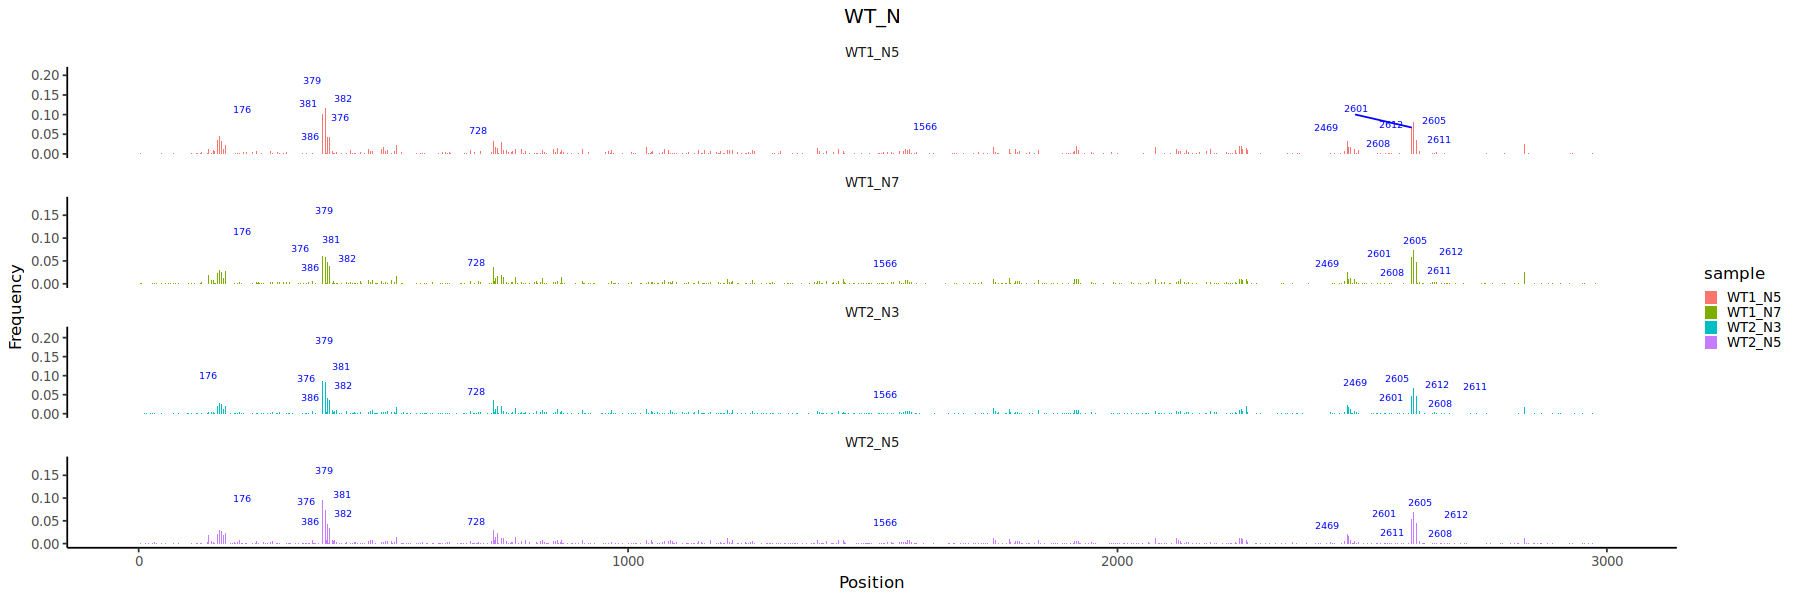

In [62]:
library(ggrepel)

df <- data.table()
my.type=1
message("Calculating ",sampleTypes[my.type], "...")
subs = samplesall[[my.type]]
for(my.sample in 1:length(subs)){
message("Calculating ", subs[my.sample], "...")
x <- read.table(paste0(PHYDIR,subs[my.sample], "_filtered_re.phy"),header = F, sep = " ",
                  colClasses=c("character","character"),skip = 2,
                  col.names = c("cellID","bi"))
if(nrow(x)>0){
  new <- sapply(as.list(1:nrow(x)),function(i){
    s <- x$bi[i]
    which(strsplit(s,"")[[1]]=="1")
  })
  new <- unlist(new)
  d <- data.table(table(new))
  colnames(d) <-c("pos","count")
  d[, freq := count/nrow(x)]
  d[, sample := subs[my.sample]]
  d[, sampleType := sampleTypes[my.type]]
  df <- rbind(df, d)
}
}
df$pos <- as.numeric(df$pos)
df$sampleType <- factor(df$sampleType, levels = sampleTypes)
##------------------------------------------------------------------------------
## WT_Normal hotpots
dsub <- df[count>0 &sampleType == sampleTypes[my.type]]
d <- data.table(table(dsub[freq>=0.04]$pos))
d <- d[N>=2] ## hotspots: freq >= 0.4 & occurred in at least 2 samples
nrow(d)
dsub[, label := ifelse(pos %in% d$V1,"y","n")]
dsub[label == "y",mean(freq)]/dsub[label == "n",mean(freq)]


p2 <- ggplot(dsub, aes(x=pos,y=freq, fill=sample))+geom_bar(stat = "identity")+
  facet_wrap(~sample,ncol=1, scales="free_y")+ ggtitle(sampleTypes[my.type])+
  xlab("Position")+ylab("Frequency")+theme_classic()+#scale_y_log10() +
  theme(plot.title = element_text(hjust = 0.5),text = element_text(size = 10),
        legend.position="right",#,axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=0.5)
        legend.key.size = unit(0.3, 'cm'),strip.background = element_blank())+
  geom_text_repel(aes(label=ifelse(label == "y", pos, "")),size=2,color="blue",max.overlaps=100)
pdf(file = paste0(OUTDIR,"figS1.hotspot_WT_Normal_selected.pdf"), width=12, height =6)
p2
dev.off()
p2

In [ ]:
p2

png 
  2

### Number of mutated sites

In [8]:
INDIR = "/data2/kantian/LineageTracing/SMALT/0.Results/2.final_phy_re/"
# INDIR = "/data2/kantian/LineageTracing/SMALT/0.Results/2.final_phy/"
OUTDIR = "/data2/kantian/LineageTracing/SMALT/0.Results/figures/"
# samplelist <- read.delim("F:/SMALT/Results/sample_list_phy_filtered.txt",header = T)
# setDT(samplelist)
# samplelist[, sampleType := paste0(cat, "_",type)]
sampleTypes = c("WT_N","Apc_N","IBD_N","Apc_P","IBD_T")
samplesall = list(c("WT1_N5","WT1_N7","WT2_N3","WT2_N5"),
                  c("68_N","72_N","71_N","75_N"),
                  c("2_N","4_N","5_N","16_N","19_N","47_N1","47_N4","47_N5","47_N6","47_N8",
                    "49_N","50_N","65_N","66_N", "17_N","151_N","142_N","148_N"),#"132_N","18_N"
                  c("68_P1","68_P2","68_P3","68_P4","68_P5-1","68_P5-2","68_P5-3",
                    "68_P5-4","68_P5-5","72_P1","72_P2","72_P4","72_P5","72_P6","72_P8","72_P9",
                    "71_P3","75_P3","75_P5","75_P8","75_P11"),
                  c("2_T2","2_T3","4_T","5_T","16_T","47_T1","47_T4","47_T5","47_T6","47_T8",
                    "49_T1","49_T3","50_T","65_T1","65_T3","66_T","19_T1","19_T3","19_T4","19_T5",
                    "132_T1","151_T4","17_T4","18_T3","18_T4","142_T1","142_T2","142_T5-4","148_T1","148_T3")
                  )
setwd(INDIR)
df <- data.table()
for(my.type in 1:5){
  samples = samplesall[[my.type]]
  for(my.sample in samples){
    # message("Calculating ", my.sample, "...")
    x <- read.delim(paste0(my.sample,"_filtered_re.phy"),header = F, sep = " ",
                    colClasses=c("character","character"),skip = 2,
                    col.names = c("cellID","bi"))
    print(nrow(x))
    if(nrow(x)>0){
      new <- sapply(as.list(1:nrow(x)),function(i){
        s <- x$bi[i]
        which(strsplit(s,"")[[1]]=="1")
      })
      new <- unlist(new)
      d <- data.table(table(new))
      colnames(d) <-c("pos","numMut")
      d[, freq := numMut/nrow(x)]
      d[, sample := my.sample]
      d[,sampleType:= sampleTypes[my.type]]
      df <- rbind(df, d)
    }
  }
}
temp <- df[, length(unique(pos)),by=c("sampleType","sample")]
# ggplot(temp, aes(x=sampleType, y=V1))+geom_boxplot()

[1] 1266
[1] 1313
[1] 3649
[1] 2780
[1] 775
[1] 2284
[1] 660
[1] 1227
[1] 206
[1] 1517
[1] 3765
[1] 3835
[1] 1375
[1] 2196
[1] 111
[1] 437
[1] 1043
[1] 3438
[1] 161
[1] 2149
[1] 253
[1] 2023
[1] 337
[1] 289
[1] 3327
[1] 4085
[1] 1042
[1] 1634
[1] 785
[1] 2012
[1] 924
[1] 196
[1] 197
[1] 454
[1] 1139
[1] 3268
[1] 1244
[1] 3753
[1] 2896
[1] 2987
[1] 2015
[1] 2919
[1] 3039
[1] 122
[1] 633
[1] 1316
[1] 506
[1] 39
[1] 55
[1] 3513
[1] 3803
[1] 3543
[1] 1043
[1] 272
[1] 728
[1] 176
[1] 938
[1] 794
[1] 1569
[1] 1075
[1] 122
[1] 343
[1] 463
[1] 660
[1] 1642
[1] 1336
[1] 778
[1] 2629
[1] 426
[1] 290
[1] 1007
[1] 161
[1] 5691
[1] 5853
[1] 749
[1] 1626
[1] 2324


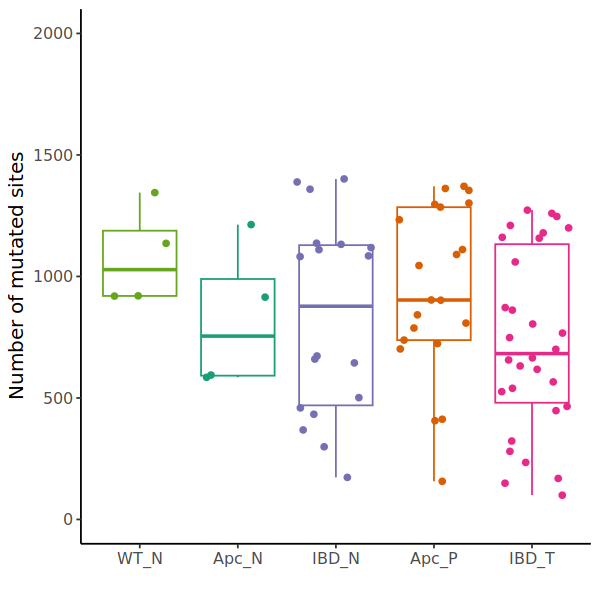

In [10]:
mycols <- c("#66A61E","#1B9E77","#7570B3","#D95F02","#E7298A") 
sampleTypes = c("WT_N","Apc_N","IBD_N","Apc_P","IBD_T")
temp$sampleType <- factor(temp$sampleType, levels =sampleTypes)
p1 <- ggplot(temp, aes(x=sampleType, y=V1,color=sampleType))+
  geom_boxplot()+geom_jitter()+ylim(0,2000)+
  labs(x="", y="Number of mutated sites")+theme_classic()+#ggtitle("")+
  theme(text = element_text(size=12),plot.title = element_text(hjust = 0.5, size = 12),
        legend.position="none")+ #axis.text.x = element_text(angle = 30, vjust = 1, hjust=1),
  scale_color_manual(values=mycols)
p1

In [25]:
summary(temp$V1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  100.0   566.0   842.0   835.8  1157.0  1401.0 

In [26]:

library(lmtest)  
confint(temp$V1, conf.level = 0.95)


ERROR: Error: $ operator is invalid for atomic vectors


In [22]:
install.packages("lmtest")

also installing the dependency ‘zoo’


Warning message in install.packages("lmtest"):
“installation of package ‘zoo’ had non-zero exit status”
Warning message in install.packages("lmtest"):
“installation of package ‘lmtest’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [17]:
nrow(temp)

[1] 77

In [18]:
sample.mean <- mean(temp$V1)
print(sample.mean)

sample.n <- length(temp$V1)
sample.sd <- sd(temp$V1)
sample.se <- sample.sd/sqrt(sample.n)
print(sample.se)

alpha = 0.05
degrees.freedom = sample.n - 1
t.score = qt(p=alpha/2, df=degrees.freedom,lower.tail=F)
print(t.score)

margin.error <- t.score * sample.se
lower.bound <- sample.mean - margin.error
upper.bound <- sample.mean + margin.error
print(c(lower.bound,upper.bound))

[1] 835.7662
[1] 42.23222
[1] 1.991673
[1] 751.6535 919.8790


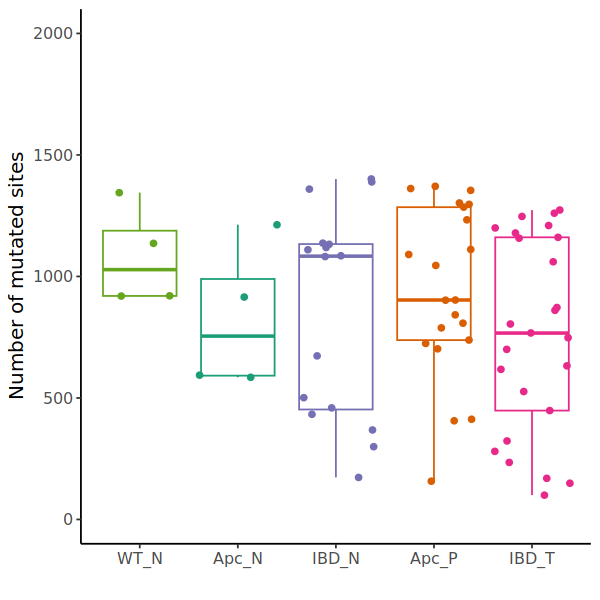

In [50]:
sampleTypes = c("WT_N","Apc_N","IBD_N","Apc_P","IBD_T")
temp$sampleType <- factor(temp$sampleType, levels =sampleTypes)
p1 <- ggplot(temp, aes(x=sampleType, y=V1,color=sampleType))+
  geom_boxplot()+geom_jitter()+ylim(0,2000)+
  labs(x="", y="Number of mutated sites")+theme_classic()+#ggtitle("")+
  theme(text = element_text(size=12),plot.title = element_text(hjust = 0.5, size = 12),
        legend.position="none")+ #axis.text.x = element_text(angle = 30, vjust = 1, hjust=1),
  scale_color_manual(values=mycols)
p1

In [51]:
pdf(file = paste0(OUTDIR,"fig1DS.3K_number_of_mutated_sites.pdf"), width=4, height = 3.5)
p1
dev.off()

png 
  2

In [38]:
summary(temp$V1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  100.0   587.2   902.5   859.4  1174.5  1401.0 

png 
  2

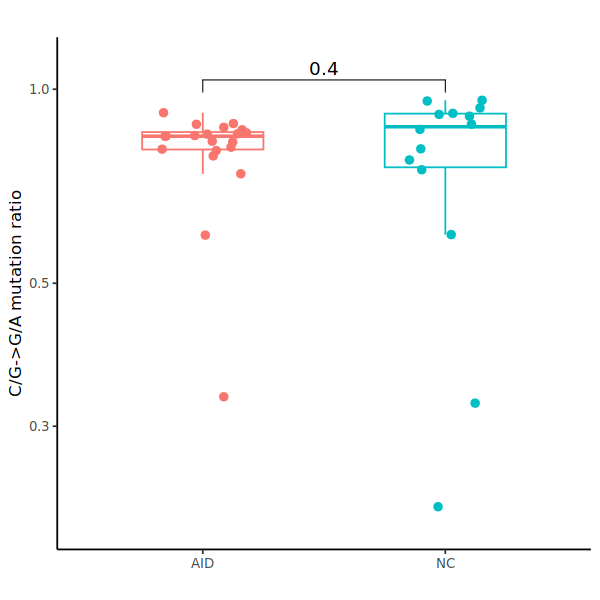

In [4]:
OUTDIR = "/data2/kantian/LineageTracing/SMALT/0.Results/figures/"
x <- read.delim("/data2/kantian/LineageTracing/SMALT/0.Results/off_target.txt",header = T)
x <- x[x$Sample != "49_2T",]
colnames(x) <- c("project","sample","ratio")
p <- ggplot(x, aes(x=project, y=ratio,color=project))+
    geom_boxplot(width=0.5,outlier.shape = NA) +
    geom_jitter(width = 0.2,cex=2) +
  labs(x="", y="C/G->G/A mutation ratio",title="")+
  theme_classic() +
  scale_y_log10(expand=expansion(mult=c(0.1,0.1))) +
  theme(text = element_text(size=10), legend.position="none") +
  stat_compare_means(comparisons = list(c("AID","NC")))#+
  #scale_color_manual(values=cols)
options(repr.plot.width = 5, repr.plot.height = 5)
p
pdf(file = paste0(OUTDIR,"figS7.off_target.pdf"), width=3.5, height = 3.5)
p
dev.off()

In [69]:
x <- read.delim("/data2/kantian/LineageTracing/SMALT/0.Results/off_target.txt",header = T)
x

Project,Sample,Ratios.C.T.and.G.A.
<chr>,<chr>,<dbl>
AID,2_2T,0.8303342
AID,49_2T,0.9192770
AID,5T,0.8729964
AID,47_6T,0.9195618
AID,4T,0.8823772
AID,16T,0.8844802
AID,47_5T,0.8651434
AID,49_3T,0.8516493
AID,68_2T,0.8031915


## 6. redundancy analysis (1G)

In [123]:
INDIR = "/data2/kantian/LineageTracing/SMALT/0.Results/2.final_phy/"
PHYDIR=INDIR
OUTDIR = "/data2/kantian/LineageTracing/SMALT/0.Results/figures/"
sampleTypes = c("WT_N","Apc_N","IBD_N","Apc_P","IBD_T")
samplesall = list(c("WT1_N5","WT1_N7","WT2_N3","WT2_N5"),
                  c("68_N","72_N","71_N","75_N"),
                  c("2_N","4_N","5_N","16_N","19_N","47_N1","47_N4","47_N5","47_N6","47_N8",
                    "49_N","50_N","65_N","66_N", "132_N","17_N","151_N","142_N","148_N"),
                  c("68_P1","68_P2","68_P3","68_P4","68_P5-1","68_P5-2","68_P5-3",
                    "68_P5-4","68_P5-5","72_P1","72_P2","72_P4","72_P5","72_P6","72_P8","72_P9",
                    "71_P3","75_P3","75_P5","75_P8","75_P11"),
                  c("2_T2","2_T3","4_T","5_T","16_T","47_T1","47_T4","47_T5","47_T6","47_T8",
                    "49_T1","49_T3","50_T","65_T1","65_T3","66_T","19_T1","19_T3","19_T4","19_T5",
                    "132_T1","151_T4","17_T4","18_T3","18_T4","142_T1","142_T2","142_T5-4","148_T1","148_T3")
                  )
# sampleTypes = c("WT_N","Apc_N","IBD_N","Apc_P","IBD_T")
# samplesall = list(c("WT1_N5","WT1_N7","WT2_N3","WT2_N5"),
#                   c("68_N","72_N","71_N","75_N"),
#                   c("2_N","4_N","5_N","16_N","19_N","47_N1","47_N4","47_N5","47_N6","47_N8",
#                     "49_N","50_N","65_N","66_N", "17_N","151_N"),#"132_N","18_N",,"142_N","148_N"
#                   c("68_P1","68_P2","68_P3","68_P4","68_P5-1","68_P5-2","68_P5-3",
#                     "68_P5-4","68_P5-5","72_P1","72_P2","72_P4","72_P5","72_P6","72_P8","72_P9",
#                     "71_P3","75_P3","75_P5","75_P8","75_P11"),
#                   c("2_T2","2_T3","4_T","5_T","16_T","47_T1","47_T4","47_T5","47_T6","47_T8",
#                     "49_T1","49_T3","50_T","65_T1","65_T3","66_T","19_T1","19_T3","19_T4","19_T5",
#                     "132_T1","151_T4","17_T4","18_T3","18_T4") #,"142_T1","142_T2","142_T5-4","148_T1","148_T3"
#                   )

mycols <- c("#66A61E","#1B9E77","#7570B3","#D95F02","#E7298A") 


In [124]:
## ref data frame
## 1. redundancy analysis within each sample
sampleTypes2 = c()
for(f in 1:5){
    temp = samplesall[[f]]
    sampleTypes2 = c(sampleTypes2, paste0(sampleTypes[f], " (n=",length(temp),")"))
}
sampleTypes2

df_all <- data.table()
df_all5 <- data.table()
d_redund <- data.table()## unique mutation profiles in each sample
for(my.type in 1:5){
  message("Calculating ",sampleTypes[my.type], "...")
  subs = samplesall[[my.type]]
  df_redund <- data.table() ## unique mutation profiles between samples in each sampleType
  for(my.sample in 1:length(subs)){
    # message("\tCalculating ", subs[my.sample], "...")
    x <- read.table(paste0(PHYDIR,subs[my.sample], "_filtered.phy"),header = F, sep = " ",
                      colClasses=c("character","character"),skip = 2,
                      col.names = c("cellID","bi"))
    df_redund <- rbind(df_redund, data.table(sample = subs[my.sample],
                                             sampleType = sampleTypes[my.type],
                                             redSeq = unique(x$bi)))
    temp <- data.table(table(x$bi))
    s <- temp$N
    d_temp <- data.table(sample = subs[my.sample], 
                         sampleType = sampleTypes[my.type],
                         redSeq = c("1","2","3","4",">=5"),
                         count = c(length(s[s==1]),length(s[s==2]),length(s[s==3]),
                                   length(s[s==4]),length(s[s>=5])))
    d_temp[, freq := round(count/sum(d_temp$count),3)]
    d_redund <- rbind(d_redund, d_temp)
  }
  s <- data.table(table(data.table(table(df_redund$redSeq))$N))
  s[, sampleType := sampleTypes2[my.type]]
  s[, freq:= round(N/sum(N),3)]
  s$V1 <- as.numeric(s$V1)
  s5 <- rbind(s[V1 <5],data.table(V1=">=5",N=sum(s[V1>=5,sum(N)]),
                                  sampleType = sampleTypes2[my.type],freq=sum(s[V1>=5,sum(freq)])))
  df_all <- rbind(df_all, s)
  df_all5 <- rbind(df_all5, s5)
}
d_redund$redSeq <- factor(d_redund$redSeq, levels = c("1","2","3","4",">=5"))
meds <- ddply(d_redund, .(sampleType,redSeq), summarize, med = median(freq),mean = mean(freq))
meds$sampleType <- factor(meds$sampleType, levels = sampleTypes)
p1 <- ggplot(meds, aes(x=redSeq, y=mean, fill = sampleType))+geom_bar(stat = "identity",position=position_dodge())+
  xlab("Clone size for unique barcodes")+ylab("Mean proportion (%)")+theme_classic()+#Unique allele frequency (cellular level)
  theme(text = element_text(size = 12),legend.key.size = unit(0.3, 'cm'),legend.position = c(0.8, 0.8),
        legend.text = element_text(size=8),legend.title = element_text(size=10))+
  labs(fill="Sample type")+ylim(0,1)+
  scale_fill_manual(values=mycols)
##----------------------
df_all5$V1 <- factor(df_all5$V1, levels = c("1","2","3","4",">=5"))
df_all5$sampleType <- factor(df_all5$sampleType, levels = sampleTypes2)
p2 <- ggplot(df_all5, aes(x=V1, y=freq, fill = sampleType))+geom_bar(stat = "identity",position=position_dodge())+
  #ggtitle("Sequence redundancy in each sample")+
  xlab("Number of samples sharing unique barcodes")+ylab("Proportion (%)")+theme_classic()+#"Unique allele frequency (sample level)"
  theme(text = element_text(size = 12),legend.key.size = unit(0.3, 'cm'),legend.position = c(0.8, 0.8),
        legend.text = element_text(size=8),legend.title = element_text(size=10))+
  labs(fill="Sample type")+
  scale_fill_manual(values=mycols)

pdf(file = paste0(OUTDIR,"fig1G_sequence_redundancy.pdf"), width=8, height = 3.5)
ggarrange(p1,p2, ncol=2, nrow=1)
dev.off()

[1] "WT_N (n=4)"   "Apc_N (n=4)"  "IBD_N (n=19)" "Apc_P (n=21)" "IBD_T (n=30)"

Calculating WT_N...

Calculating Apc_N...

Calculating IBD_N...

Calculating Apc_P...

Calculating IBD_T...



png 
  2

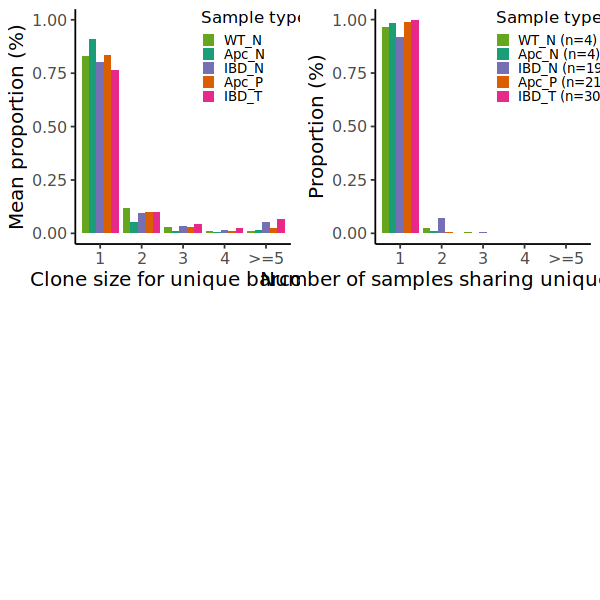

In [125]:
ggarrange(p1,p2, ncol=2, nrow=2)


In [307]:
df_all5[V1==1]

V1,N,sampleType,freq
<fct>,<int>,<fct>,<dbl>
1,6583,WT_N (n=4),0.964
1,3864,Apc_N (n=4),0.985
1,17967,IBD_N (n=14),0.968
1,23813,Apc_P (n=21),0.992
1,18345,IBD_T (n=20),1.000
